## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

import string
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

import pickle


In [2]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\indra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\indra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\indra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\indra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Loading the dataset

In [3]:
data= pd.read_csv("./Restaurant_Reviews.tsv",sep='\t')
data.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


## data preprocessing

In [4]:
data.Liked.value_counts()

Liked
1    500
0    500
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

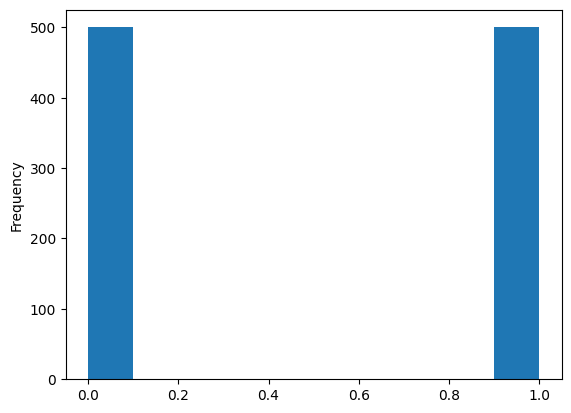

In [5]:
data.Liked.plot(kind='hist')

## Text processing

In [6]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


def preprocess_review(review):
    tokens = word_tokenize(review.lower())
    # print(tokens)
    
    tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
    # print(tokens)
    
    tokens = [re.sub(r'\b[a-z]\b', "",re.sub(r'[^\w\s | ]', '', word)) for word in tokens]
    
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # print(tokens)
    
    processed_review = ' '.join(list(filter(lambda x : x , tokens)))
    return processed_review


In [7]:
data['Review_processed']=data['Review'].apply(preprocess_review)
data.head()

,Review,Liked,Review_processed
0,Wow... Loved this place.,1,wow loved place
1,Crust is not good.,0,crust good
2,Not tasty and the texture was just nasty.,0,tasty texture nasty
3,Stopped by during the late May bank holiday of...,1,stopped late may bank holiday rick steve recom...
4,The selection on the menu was great and so wer...,1,selection menu great price


## Data Seperation

In [8]:
X = data['Review_processed']
y = data['Liked']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

29                               worst salmon sashimi
535    excellent new restaurant experienced frenchman
695                           went lunch service slow
557       think restaurant suffers trying hard enough
836                            lunch great experience
Name: Review_processed, dtype: object

## TF-IDF vectorization

In [9]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [10]:
record=535
print(X_train[record],X_train_tfidf[record],sep='\n')
print(tfidf_vectorizer.vocabulary_['excellent'])

excellent new restaurant experienced frenchman
  (0, 1225)	0.3177330370557223
  (0, 737)	0.3966035881733525
  (0, 508)	0.35296492586355055
  (0, 1385)	0.36137169936552427
  (0, 1407)	0.3966035881733525
  (0, 135)	0.3966035881733525
  (0, 980)	0.4147152694502866
468


## Modelling 

In [27]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=300),
    "SVM": SVC(kernel="linear", probability=True),
    "SVM2": SVC(kernel="poly", probability=True)   
}

In [28]:
results = []
for name, model in models.items():
    # Train the model
    model.fit(X_train_tfidf, y_train)
    # Predict on test set
    y_pred = model.predict(X_test_tfidf)
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    results.append((name, accuracy, precision, recall, f1))

In [29]:
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])
print(results_df)

                 Model  Accuracy  Precision  Recall  F1 Score
0  Logistic Regression     0.770   0.775024   0.770  0.769724
1        Random Forest     0.725   0.759752   0.725  0.718383
2                  SVM     0.795   0.802964   0.795  0.794461
3                 SVM2     0.770   0.773633   0.770  0.769885


In [39]:
best_model = results_df.loc[results_df["F1 Score"].idxmax()]
name=best_model.Model
print("\nBest Model:")
print(best_model)


Best Model:
Model             SVM
Accuracy        0.795
Precision    0.802964
Recall          0.795
F1 Score     0.794461
Name: 2, dtype: object


So the ```SVM``` linear yeids the best results as compared to the other classification models

In [40]:
best_model=SVC(kernel="linear", probability=True)

In [41]:
best_model.fit(X_train_tfidf, y_train)
y_pred = best_model.predict(X_test_tfidf)

In [42]:
print(f"\nClassification Report for {name}:\n")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


Classification Report for SVM:

              precision    recall  f1-score   support

    Negative       0.75      0.86      0.80        96
    Positive       0.85      0.73      0.79       104

    accuracy                           0.80       200
   macro avg       0.80      0.80      0.79       200
weighted avg       0.80      0.80      0.79       200



Total test 200 samples


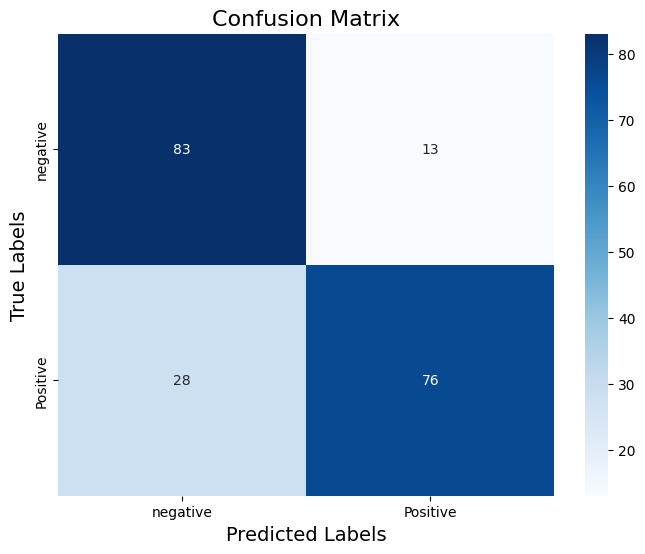

In [43]:
cm = confusion_matrix(y_test, y_pred)
print(f"Total test {len(y_test)} samples")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["negative", "Positive"], yticklabels=["negative", "Positive"])
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.show()

In [44]:
## Pipe line of processing the User input.
def preprocess_input(review):
    review = preprocess_review(review)
    review_tfidf = tfidf_vectorizer.transform([review])
    return model.predict(review_tfidf)[0]
preprocess_input("I love the food") # input testing
    

1

In [45]:

# Save the SVM model
with open("svm_model.pkl", "wb") as model_file:
    pickle.dump(model, model_file)

# Save the TF-IDF vectorizer
with open("tfidf_vectorizer.pkl", "wb") as vectorizer_file:
    pickle.dump(tfidf_vectorizer, vectorizer_file)
